In [1]:
from pyspark.sql import SparkSession

In [75]:
import numpy as np
import pandas as pd

In [23]:
import matplotlib.pyplot as plt

In [87]:
import seaborn as sns

In [2]:
spark = SparkSession\
    .builder\
    .appName("LCDataExploration")\
    .getOrCreate()

In [160]:
#df = spark.read.csv('data/LoanStats_2015_subset.csv')
df = spark.read.option('inferschema','true').csv('data/loan.csv', header=True)

In [161]:
df.take(2)

[Row(id=None, member_id=None, loan_amnt=2500, funded_amnt=2500, funded_amnt_inv=2500.0, term=' 36 months', int_rate=13.56, installment=84.92, grade='C', sub_grade='C1', emp_title='Chef', emp_length='10+ years', home_ownership='RENT', annual_inc='55000', verification_status='Not Verified', issue_d='Dec-2018', loan_status='Current', pymnt_plan='n', url=None, desc=None, purpose='debt_consolidation', title='Debt consolidation', zip_code='109xx', addr_state='NY', dti='18.24', delinq_2yrs='0', earliest_cr_line='Apr-2001', inq_last_6mths='1', mths_since_last_delinq=None, mths_since_last_record='45', open_acc='9', pub_rec='1', revol_bal='4341', revol_util='10.3', total_acc='34', initial_list_status='w', out_prncp='2386.02', out_prncp_inv='2386.02', total_pymnt='167.02', total_pymnt_inv='167.02', total_rec_prncp='113.98', total_rec_int='53.04', total_rec_late_fee='0.0', recoveries='0.0', collection_recovery_fee='0.0', last_pymnt_d='Feb-2019', last_pymnt_amnt='84.92', next_pymnt_d='Mar-2019', la

In [162]:
type(df)

pyspark.sql.dataframe.DataFrame

In [163]:
#df.head()

In [164]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

In [165]:
#Printing number of rows:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(2260668, 145)


In [166]:
#df.show(5)

In [167]:
##Registering the dataframe as a temporary table:
df.registerTempTable("Loans")

In [168]:
spark.sql("show databases").show()

+--------------------+
|        databaseName|
+--------------------+
|                  a1|
|  airline_ontime_orc|
|airline_ontime_pa...|
|        cdp_overview|
|       db_tweet_lake|
|             default|
|        frothkoetter|
|  information_schema|
|        njlamsaltest|
|           oh_canada|
|         prescribing|
|       prescribing_p|
|    prescribing_test|
|         retail_demo|
|       streaming_ref|
|                 sys|
|                test|
+--------------------+



In [169]:
spark.sql("show tables").show()

+--------+----------------+-----------+
|database|       tableName|isTemporary|
+--------+----------------+-----------+
| default|airlinesentiment|      false|
| default|             foo|      false|
| default|         james_p|      false|
| default|  james_sparlsql|      false|
| default|       james_tbl|      false|
| default|  my_first_table|      false|
| default|        products|      false|
| default|         sensors|      false|
| default|              t1|      false|
| default|  telco_churn_pq|      false|
| default|      test_india|      false|
| default|       test_kudu|      false|
| default|           words|      false|
|        |           loans|       true|
+--------+----------------+-----------+



In [170]:
group_by_grade = spark.sql("SELECT grade, MEAN(int_rate) FROM Loans GROUP BY grade ORDER BY grade")

In [171]:
group_by_grade.show()

+-----+------------------+
|grade|     avg(int_rate)|
+-----+------------------+
|    A| 7.084557521818752|
|    B| 10.67581910823055|
|    C|14.143792829200114|
|    D| 18.14330370132673|
|    E|21.829848200000292|
|    F|25.454203110048365|
|    G|28.074255424063143|
+-----+------------------+



In [172]:
group_by_grade_pd = group_by_grade.toPandas()

In [173]:
group_by_grade_pd.set_index('grade', inplace=True)

In [174]:
group_by_grade_pd.columns

Index(['avg(int_rate)'], dtype='object')

In [175]:
group_by_grade_pd = group_by_grade_pd.rename(columns={'avg(CAST(int_rate AS DOUBLE))':'AVG_Int_Rate'})

In [176]:
type(group_by_grade)

pyspark.sql.dataframe.DataFrame

In [177]:
group_by_subgrade = spark.sql("SELECT sub_grade, MEAN(int_rate) FROM Loans GROUP BY sub_grade ORDER BY sub_grade")

In [178]:
#cache what you are going to use across queries (and early and often up to available memory)
group_by_subgrade.cache()

DataFrame[sub_grade: string, avg(int_rate): double]

In [179]:
%time group_by_grade.show()

+-----+------------------+
|grade|     avg(int_rate)|
+-----+------------------+
|    A| 7.084557521818753|
|    B|10.675819108230554|
|    C|14.143792829200114|
|    D| 18.14330370132673|
|    E|21.829848200000292|
|    F|25.454203110048365|
|    G|28.074255424063143|
+-----+------------------+

CPU times: user 1.27 ms, sys: 723 µs, total: 2 ms
Wall time: 7.48 s


In [180]:
%time group_by_subgrade.show()

+---------+------------------+
|sub_grade|     avg(int_rate)|
+---------+------------------+
|       A1| 5.600266620578286|
|       A2| 6.552336764325466|
|       A3| 7.094567665063835|
|       A4|  7.56024782527037|
|       A5| 8.195023648680177|
|       B1| 9.078554423532452|
|       B2| 9.975002329786669|
|       B3|10.705048055720075|
|       B4|11.372817451517534|
|       B5|12.013505645528548|
|       C1|12.783834876594538|
|       C2| 13.53775427865421|
|       C3|14.104413629220272|
|       C4|14.878129961058553|
|       C5| 15.76832847865788|
|       D1|16.658445107411943|
|       D2|17.599961179165614|
|       D3| 18.38867045156555|
|       D4|19.073369481160068|
|       D5|20.063837744414176|
+---------+------------------+
only showing top 20 rows

CPU times: user 1.69 ms, sys: 961 µs, total: 2.65 ms
Wall time: 8.21 s


In [181]:
#group_by_subgrade.collect()

In [182]:
group_by_subgrade_pd = group_by_subgrade.toPandas()

In [183]:
group_by_subgrade_pd.head(10)

,sub_grade,avg(int_rate)
0,A1,5.600267
1,A2,6.552337
2,A3,7.094568
3,A4,7.560248
4,A5,8.195024
5,B1,9.078554
6,B2,9.975002
7,B3,10.705048
8,B4,11.372817
9,B5,12.013506


In [184]:
group_by_subgrade_pd.set_index('sub_grade', inplace=True)

In [185]:
group_by_subgrade_pd = group_by_subgrade_pd.rename(columns={'avg(CAST(int_rate AS DOUBLE))':'AVG_Int_Rate'})

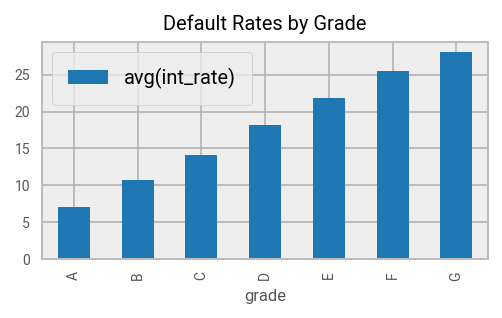

In [186]:
group_by_grade_pd.plot(kind='bar', figsize=(4,2))
plt.title('Avg Int Rate by Grade')
plt.show()

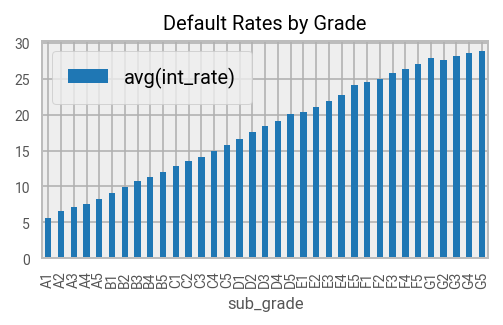

In [187]:
group_by_subgrade_pd.plot(kind='bar',figsize=(4,2))
plt.title('Avg Rates by Grade')
plt.show()

In [188]:
#removing from cache
group_by_grade.unpersist()
group_by_subgrade.unpersist()

DataFrame[sub_grade: string, avg(int_rate): double]

Data Quality Checks

In [189]:
#values recorded at time of reporting, not loan origination - would cause data leakage
future = ['acc_now_delinq','avg_cur_bal','bc_open_to_buy', 'bc_util',
           'num_actv_bc_tl','num_actv_rev_tl','num_tl_120dpd_2m','num_tl_30dpd', 'funded_amnt', 'funded_amnt_inv']

In [190]:
#Removing columns that would cause data leakage
#df.select([c for c in df.columns if c not in future])
df_new = df.drop(*future)

In [191]:
#Check dataframe columnns
#df_new.columns

In [192]:
#Investigate Nulls:
from pyspark.sql.functions import isnan, when, count, col

In [193]:
#Count number of nulls for each column:
nulls = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas()

In [194]:
#There are no nulls:
print('Total number of nulls: ', sum(nulls.T[0]>0))

Total number of nulls:  0


Checking that correct data types were inferred

In [195]:
df.dtypes 

[('id', 'string'),
 ('member_id', 'string'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'string'),
 ('mths_since_last_delinq', 'string'),
 ('mths_since_last_record', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_p

In [197]:
#Lots of columns should be numeric:
df = df.withColumn('member_id', col('member_id').cast('int'))

In [198]:
#Casting in bulk:
numeric = ['annual_inc', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_bal', 'revol_util', 'total_acc', 
'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collection_recovery_fee', 
'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 
'tot_coll_amt','tot_cur_bal','open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m',
'open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi','total_cu_tl', 'avg_cur_bal']

In [203]:
for c in future:
    df = df.withColumn(c, col(c).cast('int'))

In [204]:
df.dtypes 

[('id', 'string'),
 ('member_id', 'int'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'int'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'string'),
 ('mths_since_last_delinq', 'string'),
 ('mths_since_last_record', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_i

In [17]:
from pyspark.sql.functions import substring
df_ml = df_ml.withColumn("manufacturer", substring(col("manufacturer"), 0, 5))

NameError: name 'df_ml' is not defined

In [25]:
#Write data back to S3 here
df.write.csv('loan_clean2.csv')

Py4JJavaError: An error occurred while calling o339.csv.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:198)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:87)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:684)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:684)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:684)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:285)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:271)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:229)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:672)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 10.0 failed 4 times, most recent failure: Lost task 0.3 in stage 10.0 (TID 25, 10.10.165.77, executor 2): java.io.IOException: Mkdirs failed to create file:/home/cdsw/loan_clean2.csv/_temporary/0/_temporary/attempt_20200311041137_0010_m_000000_25 (exists=false, cwd=file:/etc/spark/work-dir)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:468)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:453)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1133)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1113)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1002)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CSVFileFormat.scala:178)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:86)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:120)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:108)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:236)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1315)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:167)
	... 33 more
Caused by: java.io.IOException: Mkdirs failed to create file:/home/cdsw/loan_clean2.csv/_temporary/0/_temporary/attempt_20200311041137_0010_m_000000_25 (exists=false, cwd=file:/etc/spark/work-dir)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:468)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:453)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1133)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1113)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1002)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CSVFileFormat.scala:178)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:86)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:120)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:108)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:236)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1315)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
#g = sns.FacetGrid(group_by_subgrade_pd, col="AVG_Int_Rate")

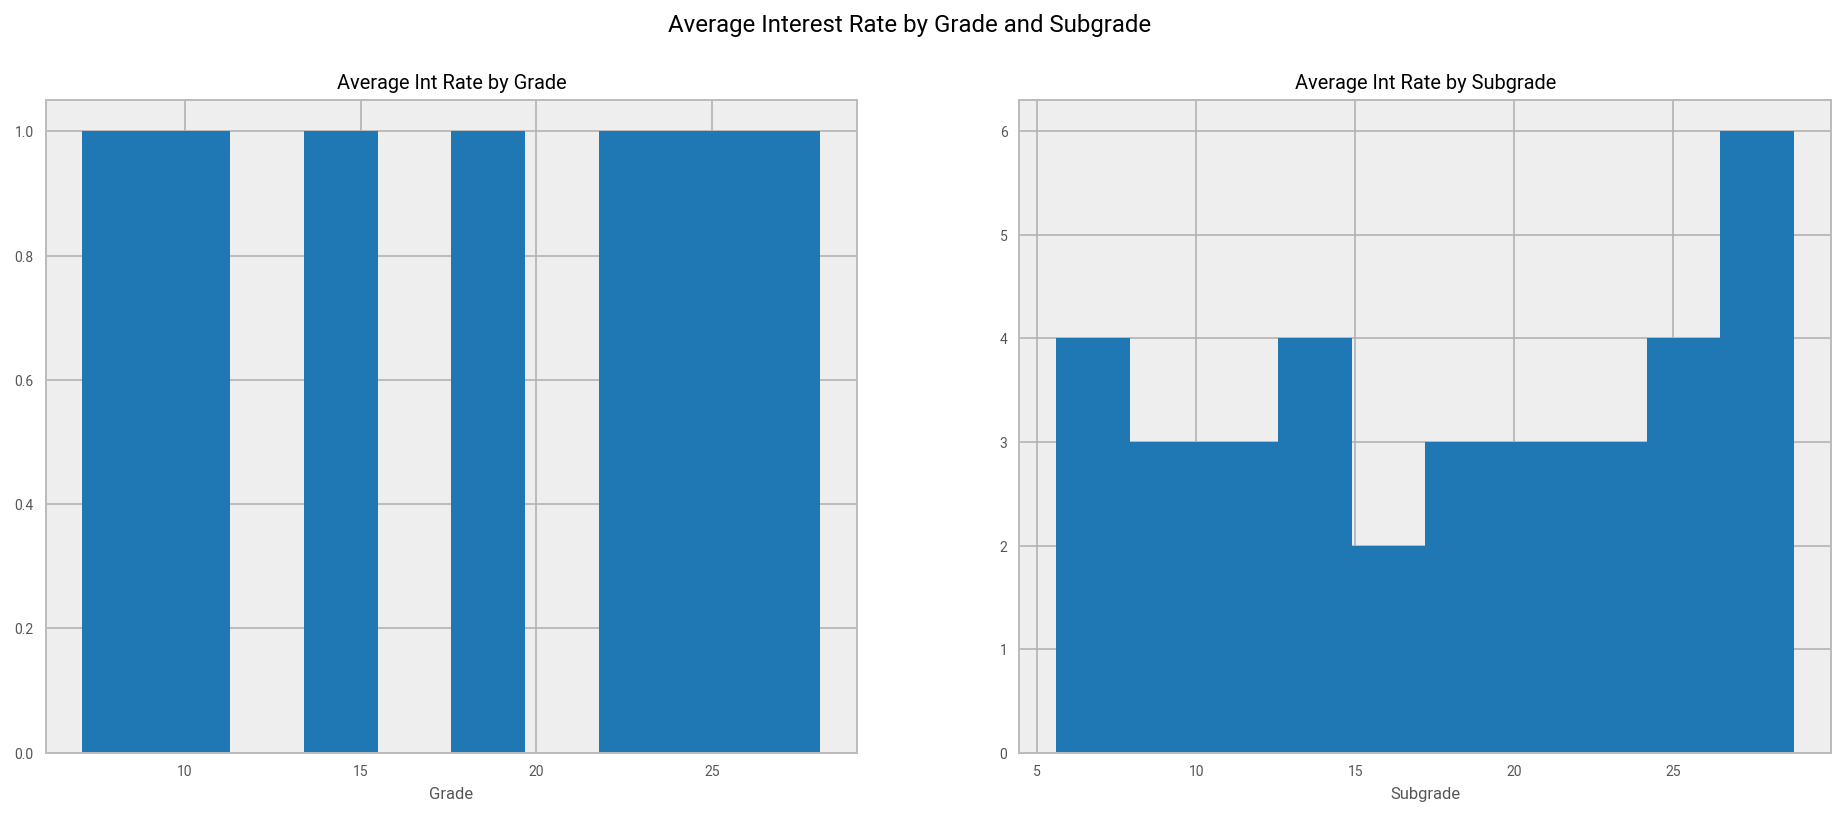

In [102]:
fig, axes = plt.subplots(1,2)
fig.suptitle('Average Interest Rate by Grade and Subgrade')
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].set_title('Average Int Rate by Grade')
axes[0].set_xlabel('Grade')
#axes[0].set_xticks(np.arange(0, len(list(group_by_grade_pd['grade']))))
#axes[0].set_xticklabels(x_tick_labels, rotation='vertical', fontsize=18)
axes[0].hist(group_by_grade_pd['AVG_Int_Rate'])

axes[1].set_title('Average Int Rate by Subgrade')
axes[1].set_xlabel('Subgrade')
#axes[1].set_xticks(np.arange(0, len(list(group_by_subgrade_pd['sub_grade']))))
#axes[1].set_xticklabels(x_tick_labels, rotation='vertical', fontsize=18)
axes[1].hist(group_by_subgrade_pd['AVG_Int_Rate'])

plt.show()